In [1]:
# Load necessary CliMA subroutines
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.Mesh.Elements: interpolationmatrix
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using CLIMA.LowStorageRungeKuttaMethod
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"
using Plots
gr()

Plots.GRBackend()

In [2]:
# Initialize CliMA
CLIMA.init()

# Add soil model and other functions
include("soilmodel.jl")
include("thermal_properties.jl")
include("kersten.jl")

kersten (generic function with 1 method)

In [3]:
# Set up domain
# NOTE: this is using 5 vertical elements, each with a 5th degree polynomial, 
# giving an approximate resolution of 5cm
const velems = 0.0:-0.2:-1 # Elements at: [0.0 -0.2 -0.4 -0.6 -0.8 -1.0] (m)
const N = 5 # Order of polynomial function between each element

# Set domain using Stached Brick Topology
topl = StackedBrickTopology(MPI.COMM_WORLD, (0.0:1,0.0:1,velems); 
    periodicity = (true,true,false),
    boundary=((0,0),(0,0),(1,2)))

# Set up grid
grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = N)

# Define thermal conductivity
κ_sand = (thermal_properties("Sand",0.35,0.05 ))
κ_clay = (thermal_properties("Clay",0.35,0.05 ))
κ_other = (thermal_properties("Other",0.35,0.05 ))

# Load Soil Model in 'm'
m = SoilModel(
    ρc = (state, aux, t) -> 2.49e6, # aux.z > -0.5 ? 2.49e6 : 2.61e6, 
    κ  = (state, aux, t) -> κ_sand, # aux.z > -0.5 ? κ_sand : κ_clay,
    initialT = (aux, t) -> (273.15 + 2.0),
    surfaceT = (state, aux, t) -> (273.15 + 12.0) + 0.5*10.0 * sinpi(2*(t/(60*60)-8)/24)
)

# Set up DG scheme
dg = DGModel( # 
  m, # "PDE part"
  grid,
  CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
  CentralNumericalFluxDiffusive(),
  CentralNumericalFluxGradient())

# Minimum spatial and temporal steps 
Δ = min_node_distance(grid)
CFL_bound = (Δ^2 / (2 * 2.42/2.49e6))
dt = CFL_bound*0.5 # TODO: provide a "default" timestep based on  Δx,Δy,Δz


141.9891653167154

In [4]:
# Define time variables
const minute = 60
const hour = 60*minute
const day = 24*hour

# Create plot state function
function plotstate(grid, Q, aux)
    # TODO:
    # this currently uses some internals: provide a better way to do this
    gridg = reshape(grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,:],:)*100
    Tg = reshape(aux.data[(1:(N+1)^2:(N+1)^3),2,:],:)
    plot(Tg, gridg, ylabel="depth (cm)", xlabel="T (°K)", yticks=-100:20:0, xlimits=(263.15,303.15), legend=false)
end

plotstate (generic function with 1 method)

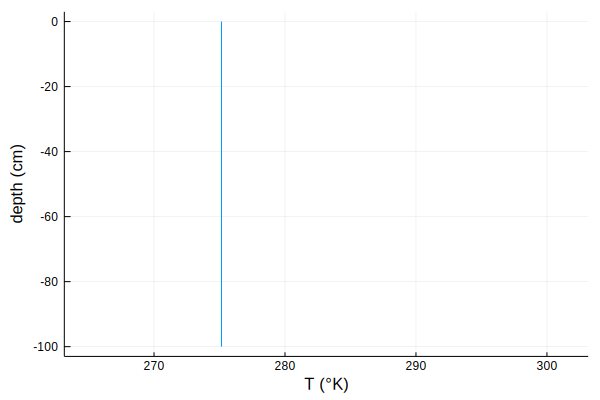

In [5]:
# state variable
Q = init_ode_state(dg, Float64(0))

# initialize ODE solver
lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)

# Plot initial state
plotstate(grid, Q, dg.auxstate)


In [6]:
# Solve for one timestep
solve!(Q, lsrk; timeend=dt)

141.9891653167154

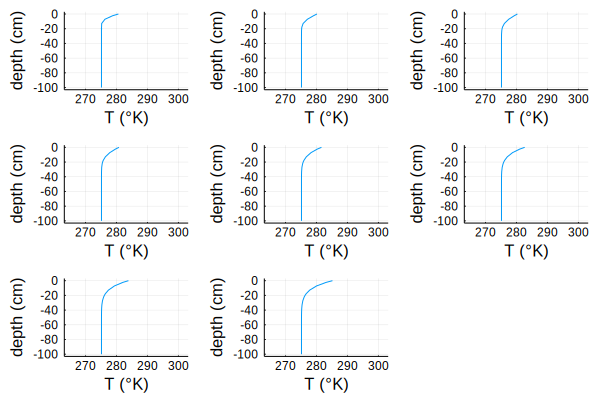

In [7]:
# run for 8 days (hours?) to get to steady state
plots = Any[]
for i = 1:8
    t = solve!(Q, lsrk; timeend=i*hour)
    push!(plots, plotstate(grid, Q, dg.auxstate))
end
plot(plots...)

In [8]:
# a function for performing interpolation on the DG grid
# TODO: use CLIMA interpolation once available
function interpolate(grid, auxstate, Zprofile)
    P = zeros(size(Zprofile))
    nelems = size(grid.vgeo, 3)
    for elem in 1:nelems
        G = grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,elem]
        I = minimum(G) .< Zprofile .<= maximum(G)
        M = interpolationmatrix(G, Zprofile[I])
        P[I] .= M*auxstate.data[(1:(N+1)^2:(N+1)^3),2,elem]
    end
    return P
end

interpolate (generic function with 1 method)

In [9]:
t_plot = 24*4 # How many time steps to plot?
Zprofile = -0.995:0.01:0 # needs to be in sorted order for contour function
Tprofile = zeros(length(Zprofile),t_plot)
hours = 0.5:1:t_plot

for (i,h) in enumerate(hours)
    t = solve!(Q, lsrk; timeend=day+h*hour)
    Tprofile[:,i] = (interpolate(grid, dg.auxstate, Zprofile))
end


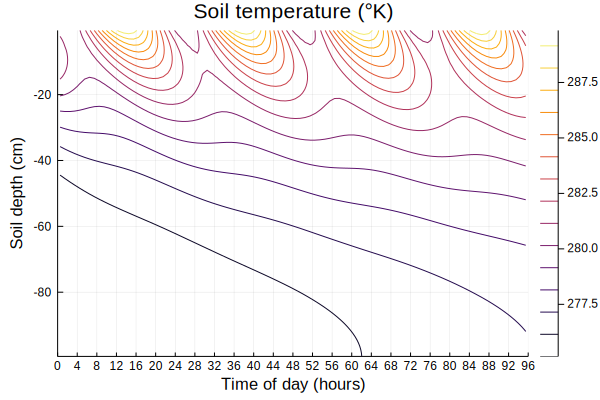

In [10]:
contour(hours, Zprofile.*100, Tprofile, 
    levels=263.15:323.15, xticks=0:4:t_plot, xlimits=(0,t_plot), 
    xlabel="Time of day (hours)", ylabel="Soil depth (cm)", title="Soil temperature (°K)")

In [11]:
# x = a ? b : c

# if a
#     x = b
# else
#     x = c
# end

In [13]:
# Load necessary CliMA subroutines
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.Mesh.Elements: interpolationmatrix
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"

ENV["CLIMA_GPU"] = "false"
using Plots
gr()

output_dir = joinpath(dirname(dirname(pathof(CLIMA))), "output", "land")
mkpath(output_dir)

# Initialize CliMA
CLIMA.init()

# Add soil model and other functions
include("soilmodel.jl")
include("thermal_properties.jl")
include("kersten.jl")

# # Set up domain
# # NOTE: this is using 5 vertical elements, each with a 5th degree polynomial, 
# # giving an approximate resolution of 5cm
# const velems = 0.0:-0.2:-1 # Elements at: [0.0 -0.2 -0.4 -0.6 -0.8 -1.0] (m)
# const N = 5 # Order of polynomial function between each element

# # Set domain using Stached Brick Topology
# topl = StackedBrickTopology(MPI.COMM_WORLD, (0.0:1,0.0:1,velems); 
#     periodicity = (true,true,false),
#     boundary=((0,0),(0,0),(1,2)))

# # Set up grid
# grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = N)

# # Define thermal conductivity
# κ_sand = (thermal_properties("Sand",0.35,0.05 ))
# κ_clay = (thermal_properties("Clay",0.35,0.05 ))
# κ_other = (thermal_properties("Other",0.35,0.05 ))

# # Load Soil Model in 'm'
# m = SoilModel(
#     ρc = (state, aux, t) -> 2.49e6, # aux.z > -0.5 ? 2.49e6 : 2.61e6, 
#     κ  = (state, aux, t) -> κ_sand, # aux.z > -0.5 ? κ_sand : κ_clay,
#     initialT = (aux, t) -> (273.15 + 2.0),
#     surfaceT = (state, aux, t) -> (273.15 + 12.0) + 0.5*10.0 * sinpi(2*(t/(60*60)-8)/24)
# )

# # Set up DG scheme
# dg = DGModel( # 
#   m, # "PDE part"
#   grid,
#   CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
#   CentralNumericalFluxDiffusive(),
#   CentralNumericalFluxGradient())

# # Minimum spatial and temporal steps 
# Δ = min_node_distance(grid)
# CFL_bound = (Δ^2 / (2 * 2.42/2.49e6))
# dt = CFL_bound*0.5 # TODO: provide a "default" timestep based on  Δx,Δy,Δz

# Set up domain
# NOTE: this is using 5 vertical elements, each with a 5th degree polynomial, 
# giving an approximate resolution of 5cm
const velems = 0.0:-0.2:-1 # Elements at: [0.0 -0.2 -0.4 -0.6 -0.8 -1.0] (m)
const N = 5 # Order of polynomial function between each element

# Set domain using Stached Brick Topology
topl = StackedBrickTopology(MPI.COMM_WORLD, (0.0:1,0.0:1,velems); 
    periodicity = (true,true,false),
    boundary=((0,0),(0,0),(1,2)))

# Set up grid
grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = N)

# Define thermal conductivity
κ_sand = (thermal_properties("Sand",0.35,0.05 ))
κ_clay = (thermal_properties("Clay",0.35,0.05 ))
κ_other = (thermal_properties("Other",0.35,0.05 ))

# Load Soil Model in 'm'

# m = SoilModel(
#     ρc = (state, aux, t) ->  aux.z > -0.5 ? 2.49e6 : 2.61e6, 
#     κ  = (state, aux, t) ->  aux.z > -0.5 ? κ_sand : κ_clay,
#     initialT = (aux, t) -> (273.15 + 12.0),
#     surfaceT = (state, aux, t) -> (273.15 + 12.0) + 0.5*10.0 * sinpi(2*(t/(60*60)-8)/24)
# )

# T_data = [ 280, 290, ...., 300]
m = SoilModel(
    ρc = (state, aux, t) ->  aux.z > -0.5 ? 2.49e6 : 2.61e6, 
    κ  = (state, aux, t) ->  aux.z > -0.5 ? κ_sand : κ_clay,
    initialT = (aux, t) -> (273.15 + 12.0),
    surfaceT = (state, aux, t) -> (273.15 + 12.0) + 0.5*10.0 * sinpi(2*(t/(60*60)-8)/24) # replace with T_data
)

# Set up DG scheme
dg = DGModel( # 
  m, # "PDE part"
  grid,
  CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
  CentralNumericalFluxDiffusive(),
  CentralNumericalFluxGradient())

# Minimum spatial and temporal steps 
Δ = min_node_distance(grid)
CFL_bound = (Δ^2 / (2 * 2.42/2.49e6))
dt = CFL_bound*0.5 # TODO: provide a "default" timestep based on  Δx,Δy,Δz



# Define time variables
const minute = 60
const hour = 60*minute
const day = 24*hour

# Create plot state function
function plotstate(grid, Q, aux)
    # TODO:
    # this currently uses some internals: provide a better way to do this
    gridg = reshape(grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,:],:)*100
    Tg = reshape(aux.data[(1:(N+1)^2:(N+1)^3),2,:],:)
    plot(Tg, gridg, ylabel="depth (cm)", xlabel="T (°K)", yticks=-100:20:0, xlimits=(263.15,303.15), legend=false)
end


# state variable
Q = init_ode_state(dg, Float64(0))

# initialize ODE solver
lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)

# Plot initial state
plotstate(grid, Q, dg.auxstate)
# plt = plotstate(m, grid, Q, dg.auxstate, 0)
savefig(joinpath(output_dir,"initial_state_T.png"))

# Solve for one timestep
solve!(Q, lsrk; timeend=dt)

# run for 8 days (hours?) to get to steady state
plots = Any[]
for i = 1:12
    t = solve!(Q, lsrk; timeend=i*hour)
    push!(plots, plotstate(grid, Q, dg.auxstate))
end
plot(plots...)
savefig(joinpath(output_dir,"state_over_time_T.png"))


# # Define time variables
# const minute = 60
# const hour = 60*minute
# const day = 24*hour

# # TODO: Add similar capability to CLIMA, also, do this more efficiently
# function get_vars_from_stack(grid::DiscontinuousSpectralElementGrid{T,dim,N},
#                              Q::MPIStateArray, # dg.auxstate or state.data
#                              bl::BalanceLaw, # SoilModelMoisture
#                              vars_fun::F) where {T,dim,N,F<:Function}
#     D = Dict()
#     FT = eltype(Q)
#     vf = vars_fun(bl,FT)
#     nz = size(Q, 3)
#     R = (1:(N+1)^2:(N+1)^3)
#     for v in flattenednames(vf)
#         D[v] = reshape(FT[getproperty(Vars{vf}(Q[i, :, e]), Symbol(v)) for i in R, e in 1:nz],:)
#     end
#     return D
# end

# # TODO: Add similar capability to CLIMA, also, do this more efficiently
# function get_grid_from_stack(grid, N)
#     return reshape(grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,:],:)*100
# end

# # Create plot state function
# function plotstate(m, grid, Q, aux, t)
#     # TODO:
#     # this currently uses some internals: provide a better way to do this
#     gridg = get_grid_from_stack(grid, N)

#     #vars = get_vars_from_stack(grid, Q, m, vars_state)
#      vars = get_vars_from_stack(grid, aux, m, vars_aux) # or use this for aux
    
#     #return plot(vars["θ"], gridg, ylabel="depth (cm)", xlabel="Vol. H20 content (m3/m3)", yticks=-100:20:0, xlimits=(0,0.3), legend=false)
#     return plot(aux["T"], gridg, ylabel="depth (cm)", xlabel="Temperature (K)", yticks=-100:20:0, xlimits=(260,310), legend=false)
# end

# # state variable
# Q = init_ode_state(dg, Float64(0))

# # initialize ODE solver
# lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)
# plt = plotstate(m, grid, Q, dg.auxstate, 0)
# savefig(joinpath(output_dir,"initial_state_T.png"))

# solve!(Q, lsrk; timeend=dt)

# # run for 8 days to get to steady state
# plots = Any[]
# for i = 1:8
#     t = solve!(Q, lsrk; timeend=i*hour)
#     push!(plots, plotstate(m, grid, Q, dg.auxstate, t))
# end
# plot(plots...)
# savefig(joinpath(output_dir,"state_over_time_T.png"))



# a function for performing interpolation on the DG grid
# TODO: use CLIMA interpolation once available
function interpolate(grid, auxstate, Zprofile)
   P = zeros(size(Zprofile))
   nelems = size(grid.vgeo, 3)
   for elem in 1:nelems
       G = grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,elem]
       I = minimum(G) .< Zprofile .<= maximum(G)
       M = interpolationmatrix(G, Zprofile[I])
       P[I] .= M*auxstate.data[(1:(N+1)^2:(N+1)^3),2,elem]
   end
   return P
end

t_plot = 24*6 # How many time steps to plot?
Zprofile = -0.995:0.01:0 # needs to be in sorted order for contour function
Tprofile = zeros(length(Zprofile),t_plot)
hours = 0.5:1:t_plot

for (i,h) in enumerate(hours)
   t = solve!(Q, lsrk; timeend=day+h*hour)
   Tprofile[:,i] = (interpolate(grid, dg.auxstate, Zprofile))
end


contour(hours, Zprofile.*100, Tprofile, 
    levels=263.15:323.15, xticks=0:4:t_plot, xlimits=(0,t_plot), 
    xlabel="Time of day (hours)", ylabel="Soil depth (cm)", title="Soil temperature (°K)")

savefig(joinpath(output_dir, "contour_T.png"))


┌ Info: Precompiling CLIMA [777c4786-024f-11e9-21a3-85d5d4106250]
└ @ Base loading.jl:1273
ERROR: LoadError: LoadError: LoadError: ArgumentError: Package CLIMA does not have NCDatasets in its dependencies:
- If you have CLIMA checked out for development and have
  added NCDatasets as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with CLIMA
Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:900
 [2] include at ./boot.jl:328 [inlined]
 [3] include_relative(::Module, ::String) at ./loading.jl:1105
 [4] include at ./Base.jl:31 [inlined]
 [5] include(::String) at /Users/emassoud/Desktop/CLIMA/src/InputOutput/Writers/Writers.jl:1
 [6] top-level scope at /Users/emassoud/Desktop/CLIMA/src/InputOutput/Writers/Writers.jl:7
 [7] include at ./boot.jl:328 [inlined]
 [8] include_relative(::Module, ::String) at ./loading.jl:1105
 [9] include at ./Base.jl:31 [inlined]
 [10] include(::String) at /U

ErrorException: Failed to precompile CLIMA [777c4786-024f-11e9-21a3-85d5d4106250] to /Users/emassoud/.julia/compiled/v1.3/CLIMA/QNtDh_hIbcG.ji.